<a href="https://colab.research.google.com/github/prabhudc/DQ/blob/master/Kaggle_Titanic_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle - Titanic Dataset Analysis

In [207]:
# Usual suspects
import pandas as pd
import numpy as np

# Pre-processing
from sklearn.preprocessing import minmax_scale
from sklearn.feature_selection import RFECV

# Model Selection
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import accuracy_score


In [163]:
# Read in the datasets from Kaggle
train = pd.read_csv('/content/drive/My Drive/DataScience/files/train.csv')
test = pd.read_csv('/content/drive/My Drive/DataScience/files/test.csv')

## Explore the dataset and feature engineering

In [164]:
train_shape = train.shape
print("Training dataset size",train_shape)
test_shape = test.shape
print("Training dataset size",test_shape)

Training dataset size (891, 12)
Training dataset size (418, 11)


Distribution of the survival across gender

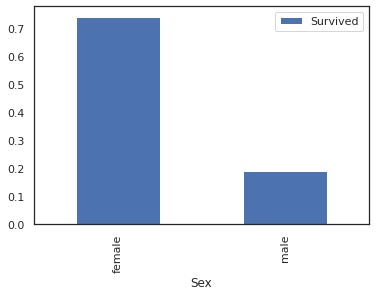

In [165]:
sex_pivot = train.pivot_table(index='Sex',values='Survived')
sex_pivot.plot.bar()
plt.show()

Distribution of the survival across passenger class

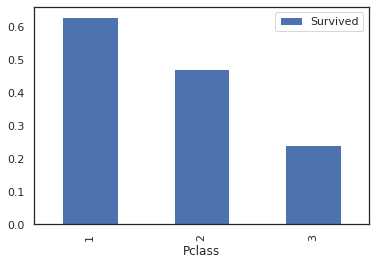

In [166]:
gender_pivot = train.pivot_table(index='Pclass',values='Survived')
gender_pivot.plot.bar()
plt.show()

Passenger class and gender are categorical variable, now let's peak into age which is numerical and continuous

In [167]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

We could create two histograms overlayed on the other to compare the age distribution across survival 

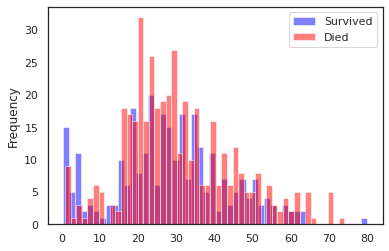

In [168]:
survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]
survived['Age'].plot.hist(color='blue', alpha=0.5,bins=50)
not_survived['Age'].plot.hist(color='red', alpha=0.5,bins=50)
plt.legend(['Survived','Died'])
plt.show()

Lets check for null values before applying any conversions

In [169]:
train['Age'].isna().sum()

177

Let us transform Age to a categorical feature

In [170]:
# Function to transfor age to a categorical feature
def process_age(df, cut_points, label_names):
  # Set nulls to a default low value
  df['Age'] = df['Age'].fillna(-0.5)
  return pd.cut(df['Age'],bins=cut_points,labels=label_names)

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ['Missing','Infant','Child','Teenager','Young Adult','Adult','Senior']

train['Age_categories'] = process_age(train, cut_points,label_names)
test['Age_categories'] = process_age(test, cut_points,label_names)

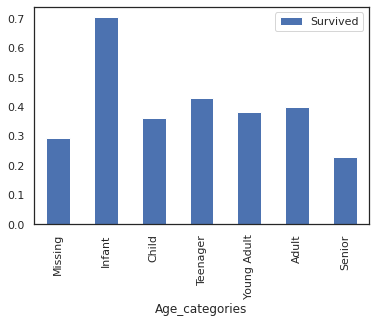

In [171]:
age_pivot = train.pivot_table(index='Age_categories',values='Survived')
age_pivot.plot.bar()
plt.show()

The categorical features need to be converted to dummy variables.

In [172]:
def create_dummies(df, column_name):
  return pd.concat([df,pd.get_dummies(df[column_name],prefix=column_name)],axis=1)

# Dummy value conversion for passenger class
train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

# Dummy value conversion for passenger Sex
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

# Dummy value conversion for passenger Age
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

## Modelling

### Logistict Regression Classifier

In [173]:
lr = LogisticRegression()
columns = columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
X = train[columns]
y = train['Survived']

lr.fit(X,y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Implement train/test split

In [174]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=0)

Run Logistic Regression on the train/test splits

In [175]:
lr.fit(train_X,train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y,predictions)
accuracy

0.8100558659217877

### Implement Cross validation

In [176]:
accuracy = np.mean(cross_val_score(lr,X,y,cv=10))
accuracy

0.8024719101123596

### Create prediction set

In [177]:
lr = LogisticRegression()
columns = columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']
X = train[columns]
y = train['Survived']
lr.fit(X,y)
holdout_predictions = lr.predict(test[columns])


Create file for download

In [178]:
submission_df = pd.concat([test['PassengerId'],pd.Series(holdout_predictions)] , axis=1,names=['PassengerId','Survived'])
submission_df.columns = ['PassengerId','Survived']
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [179]:
submission_df.shape

(418, 2)

In [180]:
submission_df.to_csv('/content/drive/My Drive/DataScience/files/submission.csv',index=False)

## Model Enhancement : Feature Preperation

From here on, we consider the test set to be holdout set

In [181]:
holdout = test

Modify the process_age function 

In [182]:
# Function to transfor age to a categorical feature
def process_age(df):
  # Set nulls to a default low value
  df['Age'] = df['Age'].fillna(-0.5)
  label_names = ['Missing','Infant','Child','Teenager','Young Adult','Adult','Senior']
  cut_points = [-1,0,5,12,18,35,60,100]
  return pd.cut(df['Age'],bins=cut_points,labels=label_names)
    

Evaluating additional features - 'SibSp','Parch','Fare','Cabin','Embarked'

In [183]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
train[columns].describe(include='all')

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,7.910400,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
75%,1.000000,0.000000,31.000000,NaN,NaN


* 'SibSp','Parch','Fare' are standard numeric
* 'Cabin' has only 204 value with remaining nulls
*  Embarked is categorical with 3 unique values


We begin by rescaling the numeric fields - SibSp, PArch & Fare

In [184]:
train['Fare'] = train['Fare'].fillna(train['Fare'].mean())
holdout['Fare'] = holdout['Fare'].fillna(train['Fare'].mean())

In [185]:
train['SibSp_scaled'] = minmax_scale(train['SibSp'],axis=0)
holdout['SibSp_scaled'] = minmax_scale(holdout['SibSp'],axis=0)

train['Parch_scaled'] = minmax_scale(train['Parch'],axis=0)
holdout['Parch_scaled'] = minmax_scale(holdout['Parch'],axis=0)

train['Fare_scaled'] = minmax_scale(train['Fare'],axis=0)
holdout['Fare_scaled'] = minmax_scale(holdout['Fare'],axis=0)

In [186]:
train['Embarked'] = train['Embarked'].fillna('S')
train = create_dummies(train,'Embarked')

holdout['Embarked'] = holdout['Embarked'].fillna('S')
holdout = create_dummies(holdout,'Embarked')

Evaluate the effectiveness of fields on the model

In [187]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns],train['Survived'])
coefficients = lr.coef_


Compare the coeffiecients to compare the weights they apply on the model.

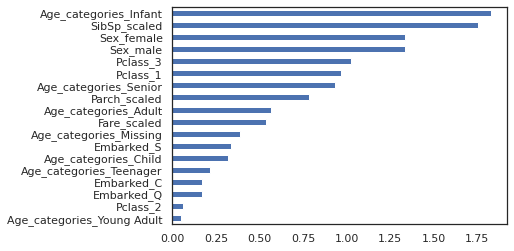

In [188]:
feature_importance  = pd.Series(np.abs(coefficients[0]),index=columns).sort_values()
feature_importance.plot.barh()
plt.show()

Now to run a model on the top 8 features and see if there is any improvement in accuracy

In [189]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

lr = LogisticRegression()

scores = cross_val_score(lr,train[columns],train['Survived'],cv=10)
accuracy = np.mean(scores)
accuracy

0.8148064918851435

Resubmit to Kaggle

In [190]:
lr.fit(train[columns],train['Survived'])
holdout_predictions = lr.predict(holdout[columns])
submission_df = pd.concat([holdout['PassengerId'],pd.Series(holdout_predictions)] , axis=1,names=['PassengerId','Survived'])
submission_df.columns = ['PassengerId','Survived']
submission_df.to_csv('/content/drive/My Drive/DataScience/files/submission.csv',index=False)

Process the feature - Fare and convert it to bins

In [191]:
# Function to transfor fare to a categorical feature
def process_fare(df):
  # Set nulls to a default low value
  df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
  label_names = ['0-12','12-50','50-100','100+']
  cut_points = [0,12,50,100,1000]
  return pd.cut(df['Fare'],bins=cut_points,labels=label_names)

# Convert to bins
train['Fare_categories'] =  process_fare(train)
holdout['Fare_categories'] =  process_fare(holdout)

# Create dummies
train = create_dummies(train,'Fare_categories')
holdout = create_dummies(holdout,'Fare_categories')

Extract information from the name

In [192]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}


extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

Extract the cabin-type which is a prefix of the cabin column

In [193]:
train['Cabin_type'] = train['Cabin'].str[0]
train['Cabin_type'] = train['Cabin_type'].fillna('Unknown')

holdout['Cabin_type'] = holdout['Cabin'].str[0]
holdout['Cabin_type'] = holdout['Cabin_type'].fillna('Unknown')

In [194]:
# Create dummies
train = create_dummies(train,'Title')
holdout = create_dummies(holdout,'Title')

# Create dummies
train = create_dummies(train,'Cabin_type')
holdout = create_dummies(holdout,'Cabin_type')

Analyze Correlation to drop Features

In [195]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']
df = train[columns]

In [196]:
def plot_correlation_heatmap(df):
  sns.set(style="white")
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  plt.show()

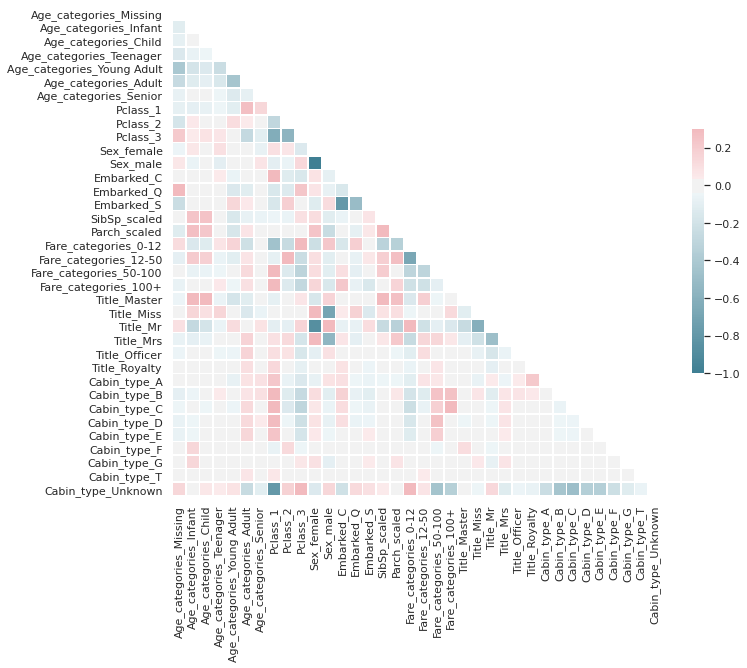

In [197]:
plot_correlation_heatmap(train[columns])

Apply feature elimination with RFECV

In [198]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)
optimized_columns = all_X.columns[selector.support_]
optimized_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

In [199]:
lr = LogisticRegression()

scores = cross_val_score(lr,train[optimized_columns],train['Survived'],cv=10)
accuracy = np.mean(scores)
accuracy

0.8226591760299625

In [200]:
lr.fit(train[optimized_columns],train['Survived'])
holdout_predictions = lr.predict(holdout[optimized_columns])
submission_df = pd.concat([holdout['PassengerId'],pd.Series(holdout_predictions)] , axis=1,names=['PassengerId','Survived'])
submission_df.columns = ['PassengerId','Survived']
submission_df.to_csv('/content/drive/My Drive/DataScience/files/submission.csv',index=False)

## Model Optimization

In [201]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']
# Baseline Logistic Regression
all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y,cv=10)
accuracy_lr = np.mean(scores)
accuracy_lr

0.8249812734082397

#### Model with K-Nearest Neighbors

In [202]:
knn = KNeighborsClassifier(n_neighbors=1)
scores = cross_val_score(knn, all_X,all_y,cv=10)
accuracy_knn = np.mean(scores)
accuracy_knn

0.7833832709113608

#### kNN hyperparameter optimization

In [203]:
knn_scores = {}
for i in range(1,50,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  scores = cross_val_score(knn, all_X,all_y,cv=10)
  knn_scores[i] = np.mean(scores)

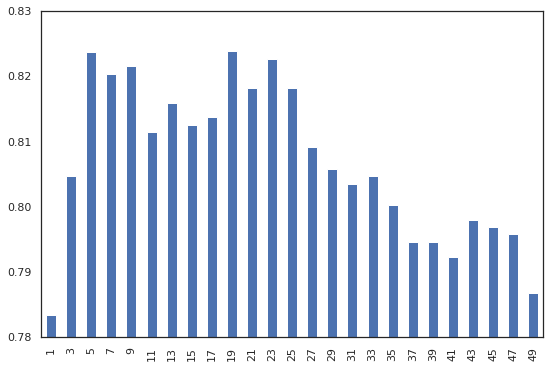

In [204]:
pd.Series(knn_scores).plot.bar(figsize=(9,6), ylim=(0.78,0.83))

plt.show()

In [205]:
knn = KNeighborsClassifier()

hyperparameters = {
    "n_neighbors": range(1,50,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_
best_knn = grid.best_estimator_

print(best_params)
print(best_score)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.8293882646691635


In [206]:
# Cabin_ype_T Not found in holdoutset 
holdout['Cabin_type_T'] = 0

holdout_predictions = best_knn.predict(holdout[columns])
submission_df = pd.concat([holdout['PassengerId'],pd.Series(holdout_predictions)] , axis=1,names=['PassengerId','Survived'])
submission_df.columns = ['PassengerId','Survived']
submission_df.to_csv('/content/drive/My Drive/DataScience/files/submission.csv',index=False)

#### Random Forests

In [208]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, all_X,all_y,cv=10)
accuracy_rf = np.mean(scores)
accuracy_rf

0.8159176029962547

#### RF hyperparameter tuning

In [221]:
rf = RandomForestClassifier()
hyperparameters = {
    "criterion": ["entropy","gini"],
    "max_depth": [5,10,12,15],
    "max_features": ['log2','sqrt'],
    "min_samples_leaf" : [1,5,7,9],
    "min_samples_split" : [3,5,7,9],
    "n_estimators" : [6,9,10,11,12]
}

grid = GridSearchCV(rf, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_
best_rf = grid.best_estimator_

print(best_params)
print(best_score)

{'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 9}
0.8428838951310862


In [222]:
holdout_predictions = best_rf.predict(holdout[columns])
submission_df = pd.concat([holdout['PassengerId'],pd.Series(holdout_predictions)] , axis=1,names=['PassengerId','Survived'])
submission_df.columns = ['PassengerId','Survived']
submission_df.to_csv('/content/drive/My Drive/DataScience/files/submission.csv',index=False)